# Исследование поведения пользователей мобильного приложения

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Также был проведен A/A/B-эксперимент. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

**Цели исследования:** 
- выяснить сколько пользователей доходит до покупки, сколько "застревает" на предыдущих шагах и на каких шагах это происходит
- исследовать результаты А/А/В-эксперимента и определить, как повлияло на поведение пользователей изменение шрифта во всем приложении

**Этапы исследования:**
1. определить 
    - сколько событий, пользователей в логе
    - сколько в среднем событий приходится на пользователя
    - определить максимальную и минимальную дату, построить гистрограмму по времени
    - определить с какого момента данные полные, отбросить старые
    - определить сколько событий и пользователей было потеряно
    - проверить из всех ли групп остались пользователи в полученной выборке
2. изучить воронку продаж
    - посмотреть, какие события есть в логах, как часто они встречаются
    - посчитать, сколько пользователей совершали каждое из этих событий, долю пользователей, которые хоть раз совершали событие.
    - предположить, в каком порядке происходят события
    - посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
    - выяснить, на каком шаге теряется больше всего пользователей, какая доля пользователей доходит от первого события до оплаты
3. изучить результаты А/А/В теста
    - определить количество пользователей в группах и проверить есть ли статистически значимая разница между выборками 246 и 247
    - определить самое популярное событие и число пользователей, совершивших это событие в каждой из контрольных групп
    - посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Повторить для остальных событий. Определить корректно ли проведено разбиение на группы?
    - произвести те же операции с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию и с объединённой контрольной группой. Сделать выводы

## Загрузка данных

Нам предоставлена таблица с логами. Каждая запись в логе — это действие пользователя, или событие.
Согласно технической документации в таблце имееются следующие столбцы:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Импортируем необходимые библиотеки и откроем таблицу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from plotly import graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import math as mth

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    logs = pd.read_csv('logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('/Users/ASUS/Учебные проекты/9_Сборный 2/logs_exp.csv', sep='\t')

In [4]:
def data_info(data):
    data.columns = data.columns.str.lower()
    display(data.head())
    print('*' * 90)
    data.info()
    print('*' * 90)
    print(f' Количество явных дубликатов - {data.duplicated().sum()}');

In [5]:
data_info(logs)

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
******************************************************************************************
 Количество явных дубликатов - 413


### Выводы

Видим, что
- записей очень много - 244 тыс.
- названия столбцов плохо читаемы, т.к. был использован camel case
- имеются явные дубликаты
- какой-то набор цифр в столбце с датой
- пропуски отсутствуют

Вышеперечисленные проблемы устраним в следующем разделе

## Подготовка данных к анализу

Переименуем столбцы

In [6]:
logs.columns = ['event', 'user', 'dt', 'group']

Поменяем тип данных в столбце с датами в datetime64. Судя по числам в столбце `event_dt` дата события указана в секундах, отсчитанных от 1го января 1970. Учтем это при переводе

In [7]:
logs['dt'] = pd.to_datetime(logs['dt'], unit='s')

Выделим дату в отдельный столбец

In [8]:
logs['date'] = logs['dt'].dt.date

Определим количество дубликатов в данных

In [9]:
logs.duplicated().sum()

413

Удалим дубликаты

In [10]:
logs = logs.drop_duplicates().reset_index()

Проверим кокрректность наших действий

In [11]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   index   243713 non-null  int64         
 1   event   243713 non-null  object        
 2   user    243713 non-null  int64         
 3   dt      243713 non-null  datetime64[ns]
 4   group   243713 non-null  int64         
 5   date    243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [12]:
logs.head()

,index,event,user,dt,group,date
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим какие имеются значения в столбцах с категориальными данными

In [13]:
logs['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [14]:
logs['group'].unique()

array([246, 248, 247], dtype=int64)

Количество и номера групп экспериментов совпадают с указанными в задании

### Выводы

Были произведены следующие действия:
1. изменили названия столбцов
2. скорректировали типы данных
3. выделили дату в отдельный столбец
4. удалили явные дубликаты
5. убедились в правильности номеров групп экспериментов

Можем продолжать исследование

## Изучение данных

Определим количество событий и количество уникальных пользователей

In [15]:
logs.agg({'event' : 'count', 'user' : 'nunique'})

event    243713
user       7551
dtype: int64

Определим, сколько в среднем событий приходится на пользователя.

In [16]:
logs.groupby('user')['event'].count().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

Получается порядка 32 событий. Также наблюдаем аномальное максимальное значение - 2300 событий. Похоже, на выброс

Посмотрим, как распределено количество событий в группах

In [17]:
logs['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

События  распределены по группам неравномерно. Больше всего событий в группе 248.

Определим минимальную и максимальную дату, а также промежуток между ними.

In [18]:
logs.agg({'dt' : [min, max]})

,dt
min,2019-07-25 04:43:36
max,2019-08-07 21:15:17


In [19]:
logs['dt'].max() - logs['dt'].min()

Timedelta('13 days 16:31:41')

Исследование начали 25 июля, а закончили 07 августа. Всего оно длилось почти 2 недели - 13 дней 16 часов.

Рассмотрим временные промежутки подробнее. Построим гистрограмму по дате и времени

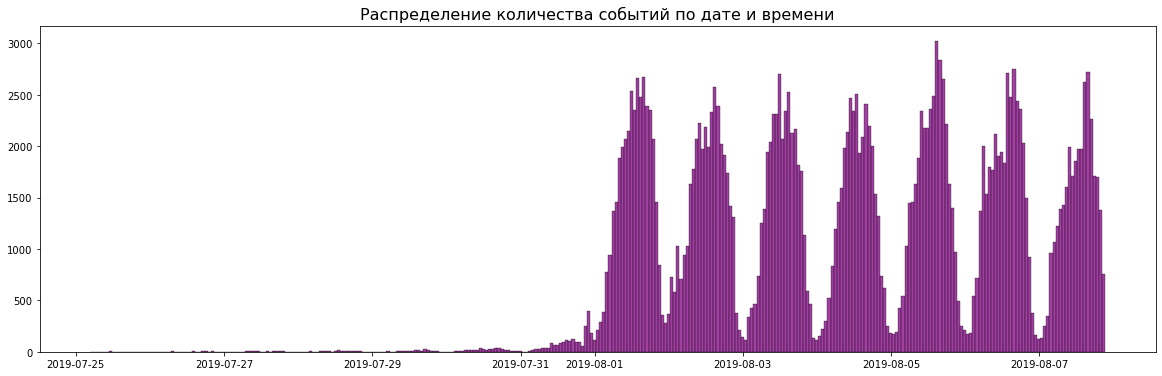

In [20]:
plt.figure(figsize=(20,6))
sns.histplot(logs['dt'], color= 'purple', bins = 329)
plt.title('Распределение количества событий по дате и времени', fontsize=16)
plt.ylabel('')
plt.xlabel('');

Наблюдаем следующее:
1. до 01 августа (01.08) практически никакой активности в приложении не происходило. Вероятно, о нем еще мало кто знал, еще не была запущена компания по продвижению.
2. после 01 августа посещения выросли
3. в ночное время приложением почти не пользуются, активность возрастает днем и вечером, что логично, т.к. в это время люди обедают и ужинают. 

Выводы справедливы при нескольких допущениях:
- сервис работает пока только в одном городе или регионе
- приложение позволяет сделать заказ круглосуточно

Считаю, что данные до 01 августа можно не учитывать в дальнейшем анализе.

Для удобства дальнейших вычислений создадим переменную с количеством пользователей и событий.

In [21]:
logs_count_old = logs.agg({'event' : 'count', 'user' : 'nunique'})
logs_count_old

event    243713
user       7551
dtype: int64

Отсекаем лишние данные

In [22]:
logs = logs.query('dt >= "2019-08-01"')

Посмотрим, как поменялась гистограмма

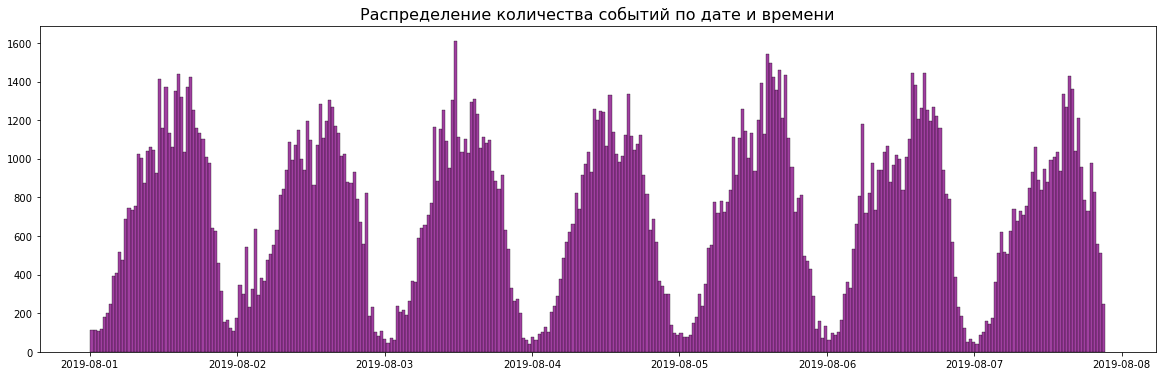

In [23]:
plt.figure(figsize=(20,6))
sns.histplot(logs['dt'], color= 'purple', bins = 329)
plt.title('Распределение количества событий по дате и времени', fontsize=16)
plt.xlabel('')
plt.ylabel('');

Всего выходит одна неделя. Проверим присутствуют ли пользователи всех групп в этом временном промежутке. Предполагаю, что да, т.к. не так уж много данных было отсечено.

In [24]:
logs.agg({'event' : 'count', 'user' : 'nunique'})

event    240887
user       7534
dtype: int64

In [25]:
changes = (logs_count_old - logs.agg({'event' : 'count', 'user' : 'nunique'})).reset_index()
changes.columns = ['name', 'count']
changes

,name,count
0,event,2826
1,user,17


Мы получили абсолютные значения, теперь посчитаем, насколько уменшилось количество пользователей и событий в относительных единицах

In [26]:
"{:.2%}".format(changes.loc[0,'count'] / logs_count_old[0])

'1.16%'

In [27]:
"{:.2%}".format(changes.loc[1,'count'] / logs_count_old[1])

'0.23%'

Было отсечено 17 пользователей (0,2% от изначального количества) и 2826 событий ( 1,1% от изначального количества)

In [28]:
logs['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

Все группы присутствуют в выборке. В группе 248 по-прежнему больше всего событий.

### Выводы

- Изучили количественные показатели
- Определили временной промежуток проведения эксперимента - с 25 июля по 07 августа
- Определили, что наибольшая активность пользователей происходит в дневное и вечернее время
- Отсекли лишние данные до 01 августа. При этом ушло 0,23% пользователей и 1,16% событий

##  Изучение воронки событий

В логах представлены следюущие события

In [29]:
logs['event'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

Предположим, что означают данные события по их названию
- **Tutorial** экран с вводной частью, обучением
- **MainScreenAppear** появление главного экрана (страницы). Первое, что видит пользователь при открытии приложения
- **OffersScreenAppear** появление экрана с предложениями, похожими запросами
- **CartScreenAppear** появление экрана с корзиной
- **PaymentScreenSuccessful** экран, сообщающий об успешной оплате

Определим, сколько раз каждое событие повторяется в эксперименте.

In [30]:
logs['event'].value_counts().reset_index()

,index,event
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Видим, что чаще всего были произвдены переходы на главный кран. Пока всё логично

Посмотрим, сколько и какая доля пользователей выполнило каждое из этих событий. Предварительно посчитаем количество уникальных пользователей.

In [31]:
total_users = logs['user'].nunique()
print('Общее количество уникальных пользоваелей -', total_users)

Общее количество уникальных пользоваелей - 7534


In [32]:
user_count = logs.groupby('event').agg({'user' : 'nunique'}).sort_values('user', ascending=False).reset_index()
user_count.columns = ['name', 'users']
user_count['rate'] = user_count['users'] / total_users

In [33]:
user_count

,name,users,rate
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Предположим последовательность данных событий:
1. **MainScreenAppear**
2. **OffersScreenAppear**
3. **CartScreenAppear**
4. **PaymentScreenSuccessful**
**Tutorial** никак связан с остальными событиями, вероятно попал в выборку по ошибке. Если бы для доступа к другим функциям необходимо было пройти некое обучение, то данное событие производилось бы намного чаще.

Перед построением воронки уберем строки с событием **Tutorial**

In [34]:
import plotly.io as pio

pio.renderers.default = "svg"

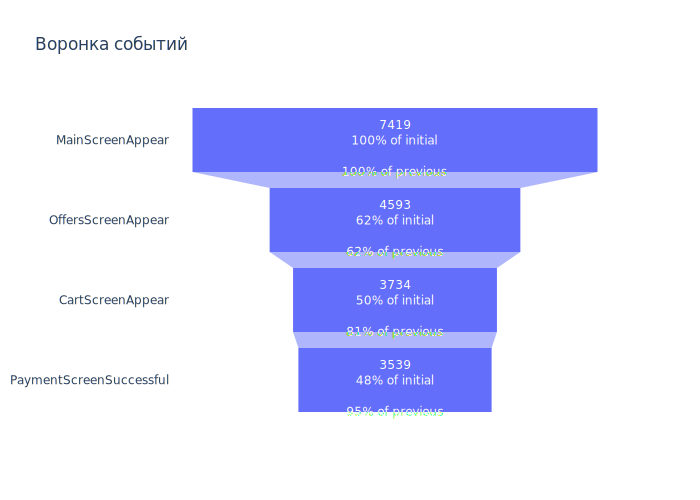

In [35]:
user_count = user_count.query('name != "Tutorial"')

fig = go.Figure(go.Funnel(
        y=user_count['name'],
        x=user_count['users'],
        textposition = "inside",
        textinfo = "value+percent previous+percent initial")
)
fig.update_layout(title_text='Воронка событий',
                   paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [36]:
user_count['previous'] = user_count['users'] / user_count['users'].shift(1, fill_value= 7419)

In [37]:
user_count

,name,users,rate,previous
0,MainScreenAppear,7419,0.984736,1.000000
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777


Из воронки событий видим, что за исключением первой ступени, процент пользователей, которые переходят с одного этапа на другой, сохраняется достаточно высоким. 
61,9% пользователей,открывших главный экран(по сути включивших приложение), перешли на страницу с предложениями.
Из них 81,3% перешли в корзину, из которых 94,8% оплатили свой заказ.

Наблюдаем очень хорошую конверсию - 48% пользователей, запустивших приложение, сделали заказ.

Больше всего пользователей теряем на первом шаге. Возможно, что-то не так с главным экраном: слишком маленькие кнопочки, вырвиглазный дизайн, сложная йерархия разделов.

## Изучение результатов эксперимента

### Количество пользователей в каждой группе

Определим количество пользователей в каждой экспериментальной группе и долю от общего количества

In [38]:
user_group = logs.query('event != "Tutorial"').groupby('group').agg({'user' : 'nunique'}).reset_index()
user_group.columns = ['group', 'users']
total_users = user_group['users'].sum()
user_group['rate'] = (user_group['users'] / total_users).map("{:.2%}".format)

In [39]:
user_group

,group,users,rate
0,246,2483,32.97%
1,247,2512,33.36%
2,248,2535,33.67%


Сохраним количество пользователей в каждой группе в отдельную переменную для дальнейших расчетов

In [40]:
users_246 = user_group.loc[0,'users']
users_247 = user_group.loc[1,'users']
users_248 = user_group.loc[2,'users']

Построим воронку событий для с разбивкой на экспериментальные группы

In [41]:
user_count_groups = logs.query('event != "Tutorial"').pivot_table(index='event', columns='group', values='user',
                                                                aggfunc='nunique').reset_index()
user_count_groups.columns = ['event', '246', '247', '248']
user_count_groups = user_count_groups.sort_values('246', ascending=False)
user_count_groups

,event,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Интересно, что количество пользователей, перешедших на главный экран не равно количеству всех пользователей в каждой группе. Значит некоторые пользователи не пользовались приложением,а только скачали его.

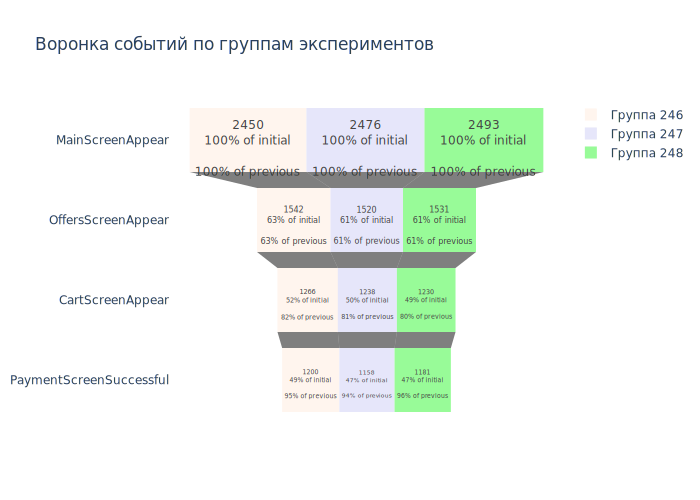

In [42]:
fig2 = go.Figure()

fig2.add_trace(go.Funnel(
    name = 'Группа 246',
    y = user_count_groups['event'],
    x = user_count_groups['246'],
    textinfo = "value+percent previous+percent initial",
    marker = {"color": ["seashell", "seashell", "seashell", "seashell"]}
))

fig2.add_trace(go.Funnel(
    name = 'Группа 247',
    orientation = "h",
    y = user_count_groups['event'],
    x = user_count_groups['247'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial",
    marker = {"color": ["lavender", "lavender", "lavender", "lavender"]}
))

fig2.add_trace(go.Funnel(
    name = 'Группа 248',
    orientation = "h",
    y = user_count_groups['event'],
    x = user_count_groups['248'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial",
    marker = {"color": ["palegreen", "palegreen", "palegreen", "palegreen"]}
))

fig2.update_layout(title_text='Воронка событий по группам экспериментов',
                   paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')
fig2.show()

Видим, что разница в долях между контрольными группами небольшая - не более 1%. Только при переходе с главного экрана на экран с предложениями доли отличаются на 2%. Проверим далее является ли статистически значимой подобная разница

### Проверка равенства долей двух контрольных групп

Добавим доли пользователей, перешедших с одного экрана на другой, в сводную таблицу. 

In [43]:
user_count_groups['rate_246'] = user_count_groups['246'] / user_count_groups['246'].shift(1,fill_value=user_count_groups.loc[0,'246'])
user_count_groups['rate_247'] = user_count_groups['247'] / user_count_groups['247'].shift(1,fill_value=user_count_groups.loc[0,'247'])
user_count_groups['rate_248'] = user_count_groups['248'] / user_count_groups['248'].shift(1,fill_value=user_count_groups.loc[0,'248'])
user_count_groups.reset_index(drop=True, inplace=True)
user_count_groups

,event,246,247,248,rate_246,rate_247,rate_248
0,MainScreenAppear,2450,2476,2493,1.935229,2.000000,2.026829
1,OffersScreenAppear,1542,1520,1531,0.629388,0.613893,0.614120
2,CartScreenAppear,1266,1238,1230,0.821012,0.814474,0.803396
3,PaymentScreenSuccessful,1200,1158,1181,0.947867,0.935380,0.960163


Определим, есть ли разница в двух контрольных А/А группах - 246 и 247. Для этого проверим гипотезу о равенстве долей двух выборок для каждого изменения экрана.

Зададим нулевую и альтернативную гипотезы.

H0: доли выборок 246 и 247 равны

H1: доли выборок 246 и 247 не равны

Уровень статистической значимости alpha зададим равным 0.05

In [44]:
alpha = 0.05

Проведем z-тест для долей зрителей из контрольных групп, перешедших с одного экрана на другой. Упакуем формулу в функцию.

In [45]:
def ztest(r1,r2,n1,n2):
    p1 = r1 / n1
    p2 = r2 / n2
    p = (r1 + r2) / (n1 + n2)  
    z_value = (p1 - p2) / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < alpha:
        return display(p_value, 'Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else: return display(p_value, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

1. Сравним доли контрольных групп пользователей при переходе с главного экрана на экран с предложениями

In [46]:
ztest(user_count_groups.loc[1,'246'],
      user_count_groups.loc[1,'247'],
      user_count_groups.loc[0,'246'],
      user_count_groups.loc[0,'247'])

0.2622344959255778

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

2. Сравним доли контрольных групп пользователей при переходе с экрана с предложениями на экран с корзиной

In [47]:
ztest(user_count_groups.loc[2,'246'],
      user_count_groups.loc[2,'247'],
      user_count_groups.loc[1,'246'],
      user_count_groups.loc[1,'247'])

0.6393754713145263

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

3. Сравним доли контрольных групп пользователей при переходе с экрана с корзиной на экран с оплатой

In [48]:
ztest(user_count_groups.loc[3,'246'],
      user_count_groups.loc[3,'247'],
      user_count_groups.loc[2,'246'],
      user_count_groups.loc[2,'247'])

0.18243439408067652

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

#### Выводы

Результаты тестов показали, что статистически значимых различий между долями нет. При этом p-value в первом и третьем сравнении значительно меньше, чем во втором, и достаточно близка к заданному уровню статистической значимости. Разница в долях во втором случае, действительно наименьшая - менее одного процента

In [49]:
user_count_groups['rate_246'] - user_count_groups['rate_247']

0   -0.064771
1    0.015494
2    0.006538
3    0.012488
dtype: float64

### Проверка равенства долей пользователей двух контрольных групп по событиям

Посчитаем и сравним доли пользователей, совершивших событие, от общего количества пользователей в данной группе.

In [50]:
groups_events = logs.query('event != "Tutorial"').pivot_table(index='event', columns='group', aggfunc=({'user' : 'nunique'})).reset_index()
groups_events.columns= ['events', '246', '247', '248']
groups_events = groups_events.sort_values('246', ascending=False).reset_index(drop=True)

groups_events['rate_246'] = groups_events['246'] / users_246
groups_events['rate_247'] = groups_events['247'] / users_247
groups_events['rate_248'] = groups_events['248'] / users_248

In [51]:
groups_events

,events,246,247,248,rate_246,rate_247,rate_248
0,MainScreenAppear,2450,2476,2493,0.986710,0.985669,0.983432
1,OffersScreenAppear,1542,1520,1531,0.621023,0.605096,0.603945
2,CartScreenAppear,1266,1238,1230,0.509867,0.492834,0.485207
3,PaymentScreenSuccessful,1200,1158,1181,0.483286,0.460987,0.465878


Зададим нулевую и альтернативную гипотезы.

H0: доли выборок 246 и 247 равны

H1: доли выборок 246 и 247 не равны

Уровень статистической значимости alpha зададим равным 0.05

In [52]:
groups_events.set_index('events', inplace=True)
for event in groups_events.index:
    print(event)
    ztest(groups_events.loc[event, '246'], groups_events.loc[event, '247'],users_246,users_247)

MainScreenAppear


0.7526703436483038

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

OffersScreenAppear


0.24786096925282264

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

CartScreenAppear


0.22867643757335676

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

PaymentScreenSuccessful


0.11446627829276612

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

#### Выводы

По всем событиям нет оснований считать доли разными, соответственно разбиение на группы работает корректно

### Проверка равенства долей экспериментальной группы и контрольных групп

Теперь посмотрим, есть ли различия между долями экспериментальной группы (в которой изменили шрифт) и долями контрольных групп

#### Проверка равенства долей экспериментальной группы и контрольной группы 246

In [53]:
groups_events

,246,247,248,rate_246,rate_247,rate_248
events,,,,,,
MainScreenAppear,2450,2476,2493,0.986710,0.985669,0.983432
OffersScreenAppear,1542,1520,1531,0.621023,0.605096,0.603945
CartScreenAppear,1266,1238,1230,0.509867,0.492834,0.485207
PaymentScreenSuccessful,1200,1158,1181,0.483286,0.460987,0.465878


In [54]:
for event in groups_events.index:
    print(event)
    ztest(groups_events.loc[event,'246'], groups_events.loc[event,'248'],users_246, users_248)

MainScreenAppear


0.3387114076159288

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

OffersScreenAppear


0.21442476639710506

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

CartScreenAppear


0.08067367598823139

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

PaymentScreenSuccessful


0.21693033984516674

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

#### Проверка равенства долей экспериментальной группы и контрольной группы 247

In [55]:
for event in groups_events.index:
    print(event)
    ztest(groups_events.loc[event,'247'], groups_events.loc[event,'248'],users_247, users_248)

MainScreenAppear


0.5194964354051703

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

OffersScreenAppear


0.9333751305879443

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

CartScreenAppear


0.5878284605111943

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

PaymentScreenSuccessful


0.7275718682261119

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

#### Проверка равенства долей экспериментальной группы и объединенной контрольной группы

In [56]:
groups_events['246_247'] = groups_events['246'] + groups_events['247']
users_246_247 = users_246 + users_247

In [57]:
groups_events

,246,247,248,rate_246,rate_247,rate_248,246_247
events,,,,,,,
MainScreenAppear,2450,2476,2493,0.986710,0.985669,0.983432,4926
OffersScreenAppear,1542,1520,1531,0.621023,0.605096,0.603945,3062
CartScreenAppear,1266,1238,1230,0.509867,0.492834,0.485207,2504
PaymentScreenSuccessful,1200,1158,1181,0.483286,0.460987,0.465878,2358


In [58]:
for event in groups_events.index:
    print(event)
    ztest(groups_events.loc[event,'246_247'], groups_events.loc[event,'248'],users_246_247, users_248)

MainScreenAppear


0.3486684291093256

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

OffersScreenAppear


0.44582745409482394

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

CartScreenAppear


0.18683558686831558

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

PaymentScreenSuccessful


0.6107918742187335

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Немного скорректируем функцию и создадим таблицу со всеми значениями p-value.

In [59]:
def ztest_n(r1,r2,n1,n2):
    p1 = r1 / n1
    p2 = r2 / n2
    p = (r1 + r2) / (n1 + n2)  
    z_value = (p1 - p2) / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value.round(4)
    

In [60]:
diff_a1_a2 = []
diff_a1_b = []
diff_a2_b = []
diff_a_b = []

for event in groups_events.index:
    diff_a1_a2.append(ztest_n(groups_events.loc[event, '246'], groups_events.loc[event, '247'],users_246,users_247))
for event in groups_events.index:
    diff_a1_b.append(ztest_n(groups_events.loc[event,'246'], groups_events.loc[event,'248'],users_246, users_248))
for event in groups_events.index:
    diff_a2_b.append(ztest_n(groups_events.loc[event,'247'], groups_events.loc[event,'248'],users_247, users_248))    
for event in groups_events.index:
    diff_a_b.append(ztest_n(groups_events.loc[event,'246_247'], groups_events.loc[event,'248'],users_246_247, users_248))

    
p_values = pd.DataFrame({'Сравнение контрольных групп' : diff_a1_a2,
                         'Сравнение с группой 246' : diff_a1_b,
                         'Сравнение с группой 247' : diff_a2_b,
                         'Сравнение с объединенной группой' : diff_a_b})    

In [61]:
p_values.set_index(groups_events.index, inplace=True)

In [62]:
p_values

,Сравнение контрольных групп,Сравнение с группой 246,Сравнение с группой 247,Сравнение с объединенной группой
events,,,,
MainScreenAppear,0.7527,0.3387,0.5195,0.3487
OffersScreenAppear,0.2479,0.2144,0.9334,0.4458
CartScreenAppear,0.2287,0.0807,0.5878,0.1868
PaymentScreenSuccessful,0.1145,0.2169,0.7276,0.6108


#### Выводы

Во всех проведенных тестах был получен одинаковый результат : доли выборок в экспериментальной группе и в контрольных группах равны.

При этом некая разница между группами 246 и 247 все-такие наблюдается, результаты при поочередном сравнении с экспериментальной группой не идентичны . Видим большие отличия в значении p-value. Это наиболее заметно в сравнении с группой 246, где на третьем событии p-value очень близко к уровню статистической значимости, а в сравнении с группой 247 p-value почти 60%.



### Уровень статистической значимости

При проверке статистических гипотез был выбран уровень статистической значимости равный 0.05.

Всего было сделано 19 проверок.

По полученным результатам могу сказать, что только увеличение уровня статистической значимости может изменить некоторые выводы, но тем самым мы уменьшим точность проверки.

Считаю, что уровень статистической значимости необходимо оставить прежним.

## Выводы

1. До покупки доходит порядка 48% пользователей, зашедших в приложение, что  ,по моему мнению, является крайне хорошим результатом. При этом больше всего пользователей теряем на первом шаге. Возможно, что-то не так с главным экраном: слишком маленькие кнопочки, вырвиглазный дизайн, сложная йерархия разделов.

2. По результатам тестов можно сделать вывод, что введение новых шрифтов никак не повлияло на поведение пользователей.Доли пользователей во всех группах практически идентичны и статистически значимых различий мы не наблюдаем. Возможно, что они даже не заметили какие-либо изменения. С точки зрения потраченных ресурсов - это ,конечно, ошибка, с точки зрения продукта - это не так уж плохо. Если всё работает и как прежде показывает хорошие результаты, значит как минимум изменение шрифтов не ухудшило ситуацию.